In [5]:
import numpy as np
import cv2
import scipy
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy.linalg as LA

In [26]:
def fit_fundamental(matches, normalized=False, wh=None):
    
    N = len(matches)
    print(matches)
    T = None
    w, h = wh
    if (normalized):
        mean = (np.mean(matches[:,:2], 0) + np.mean(matches[:,2:], 0)) / 2
        T = np.array([[1,0,-mean[0]],[0,1,-mean[1]],[0,0,1]])
        scaled_msd = (1 / (2 * N)) * (np.sum( np.sum( matches[:,:2] ** 2, axis=1 ) ** 0.5) + np.sum( np.sum( matches[:,2:] ** 2, axis=1 ) ** 0.5) )
        T_prime = np.array([[1/scaled_msd, 0, 0],[0, 1/scaled_msd, 0],[0, 0, 1]])
        matches[:,:2] = np.matmul(T_prime, np.matmul(T, np.concatenate([matches[:,:2], np.ones((N,1))], 1).T)).T[:,:2]
        matches[:,2:] = np.matmul(T_prime, np.matmul(T, np.concatenate([matches[:,2:], np.ones((N,1))], 1).T)).T[:,:2]
    
    print(matches)
    
    u = matches[:,0]
    v = matches[:,1]
    u_pr = matches[:,2]
    v_pr = matches[:,3]
    
    A = np.zeros((N, 8))
    A[:,0] = u_pr * u
    A[:,1] = u_pr * v
    A[:,2] = u_pr
    A[:,3] = v_pr * u
    A[:,4] = v_pr * v
    A[:,5] = v_pr
    A[:,6] = u
    A[:,7] = v
    
    targets = -1 * np.ones(N)
    
    F = LA.lstsq(A, targets)[0]
    
    F = np.append(F, 1).reshape((3,3))
    
    U, s, V = LA.svd(F)
    s[-1] = 0
    F = np.matmul(np.matmul(U, np.diag(s)), V)
    
    if (normalized):
        F = np.matmul(np.matmul(T.T, F), T_prime)
    
    return F
    
    

In [27]:
def sample_code(image1, image2, matches, normalized=False):
    I1 = Image.open(image1)
    I2 = Image.open(image2)
    matches = np.loadtxt(matches)

    # this is a N x 4 file where the first two numbers of each row
    # are coordinates of corners in the first image and the last two
    # are coordinates of corresponding corners in the second image: 
    # matches(i,1:2) is a point in the first image
    # matches(i,3:4) is a corresponding point in the second image

    N = len(matches)

    ##
    ## display two images side-by-side with matches
    ## this code is to help you visualize the matches, you don't need
    ## to use it to produce the results for the assignment
    ##

    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1;
    I3[:,I1.size[0]:,:] = I2;
    
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(I3.astype(float))
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    plt.show()

    ##
    ## display second image with epipolar lines reprojected 
    ## from the first image
    ##

    # first, fit fundamental matrix to the matches
    F = fit_fundamental(matches, normalized, I1.size); # this is a function that you should write
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    # the first image to get epipolar lines in the second image

    # find points on epipolar lines L closest to matches(:,3:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
    closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I2).astype(float))
    ax.plot(matches[:,2],matches[:,3],  '+r')
    ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
    plt.show()

In [28]:

def my_main():
    
    
    image_dir = "MP3_part2_data/"
    sample_code(image_dir+"lab1.jpg", image_dir+"lab2.jpg", image_dir+"lab_matches.txt")
    sample_code(image_dir+"lab1.jpg", image_dir+"lab2.jpg", image_dir+"lab_matches.txt", normalized=True)
    sample_code(image_dir+"library1.jpg", image_dir+"library2.jpg", image_dir+"library_matches.txt")
    sample_code(image_dir+"library1.jpg", image_dir+"library2.jpg", image_dir+"library_matches.txt", normalized=True)
    
    
    

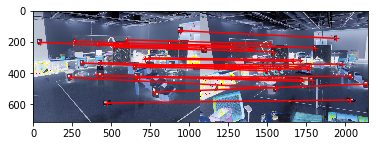

[[ 880.  214.  731.  238.]
 [  43.  203.   22.  248.]
 [ 270.  197.  204.  230.]
 [ 886.  347.  903.  342.]
 [ 745.  302.  635.  316.]
 [ 943.  128.  867.  177.]
 [ 476.  590.  958.  572.]
 [ 419.  214.  328.  244.]
 [ 317.  335.  426.  386.]
 [ 783.  521. 1064.  470.]
 [ 235.  427.  480.  495.]
 [ 665.  429.  964.  419.]
 [ 655.  362.  695.  374.]
 [ 427.  333.  505.  372.]
 [ 412.  415.  645.  452.]
 [ 746.  351.  692.  359.]
 [ 434.  415.  712.  444.]
 [ 525.  234.  465.  263.]
 [ 716.  308.  591.  324.]
 [ 602.  187.  447.  213.]]
[[ 880.  214.  731.  238.]
 [  43.  203.   22.  248.]
 [ 270.  197.  204.  230.]
 [ 886.  347.  903.  342.]
 [ 745.  302.  635.  316.]
 [ 943.  128.  867.  177.]
 [ 476.  590.  958.  572.]
 [ 419.  214.  328.  244.]
 [ 317.  335.  426.  386.]
 [ 783.  521. 1064.  470.]
 [ 235.  427.  480.  495.]
 [ 665.  429.  964.  419.]
 [ 655.  362.  695.  374.]
 [ 427.  333.  505.  372.]
 [ 412.  415.  645.  452.]
 [ 746.  351.  692.  359.]
 [ 434.  415.  712.  444.]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


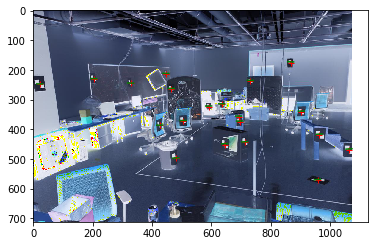

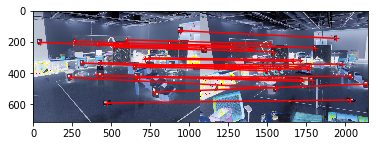

[[ 880.  214.  731.  238.]
 [  43.  203.   22.  248.]
 [ 270.  197.  204.  230.]
 [ 886.  347.  903.  342.]
 [ 745.  302.  635.  316.]
 [ 943.  128.  867.  177.]
 [ 476.  590.  958.  572.]
 [ 419.  214.  328.  244.]
 [ 317.  335.  426.  386.]
 [ 783.  521. 1064.  470.]
 [ 235.  427.  480.  495.]
 [ 665.  429.  964.  419.]
 [ 655.  362.  695.  374.]
 [ 427.  333.  505.  372.]
 [ 412.  415.  645.  452.]
 [ 746.  351.  692.  359.]
 [ 434.  415.  712.  444.]
 [ 525.  234.  465.  263.]
 [ 716.  308.  591.  324.]
 [ 602.  187.  447.  213.]]
[[ 0.4209717  -0.17614029  0.20628946 -0.1415606 ]
 [-0.78499497 -0.19198932 -0.8152522  -0.1271524 ]
 [-0.45792874 -0.20063424 -0.55302289 -0.15308717]
 [ 0.42961662  0.01548882  0.45411057  0.00828472]
 [ 0.22646095 -0.0493481   0.0679707  -0.02917661]
 [ 0.51174339 -0.30005085  0.40224104 -0.22945065]
 [-0.16111974  0.36560818  0.53335569  0.33967341]
 [-0.2432465  -0.17614029 -0.37436116 -0.13291568]
 [-0.39021018 -0.00180103 -0.23316076  0.07168081]


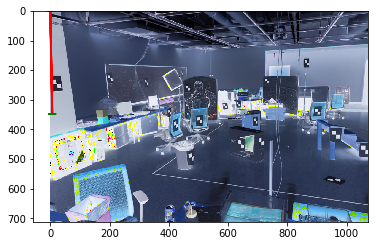

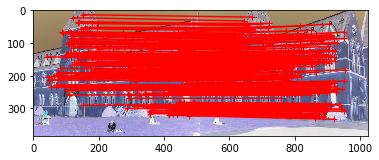

[[460.0805   104.9175   406.3635    82.941   ]
 [382.9605   108.0555   334.3105    93.6585  ]
 [106.718    102.545    115.988    109.5505  ]
 ...
 [231.88115  103.41166  207.82166  101.60805 ]
 [384.81      78.406745 336.47062   60.910215]
 [443.79631   67.695265 392.18692   42.129562]]
[[460.0805   104.9175   406.3635    82.941   ]
 [382.9605   108.0555   334.3105    93.6585  ]
 [106.718    102.545    115.988    109.5505  ]
 ...
 [231.88115  103.41166  207.82166  101.60805 ]
 [384.81      78.406745 336.47062   60.910215]
 [443.79631   67.695265 392.18692   42.129562]]


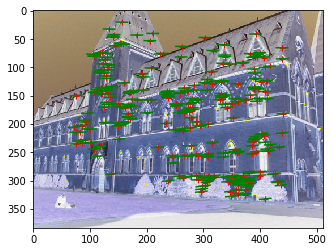

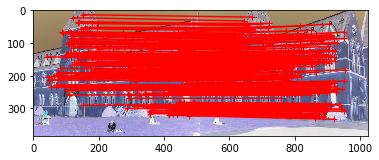

[[460.0805   104.9175   406.3635    82.941   ]
 [382.9605   108.0555   334.3105    93.6585  ]
 [106.718    102.545    115.988    109.5505  ]
 ...
 [231.88115  103.41166  207.82166  101.60805 ]
 [384.81      78.406745 336.47062   60.910215]
 [443.79631   67.695265 392.18692   42.129562]]
[[ 0.48871647 -0.23439587  0.3362886  -0.29675659]
 [ 0.26988002 -0.22549145  0.13183031 -0.26634451]
 [-0.51398835 -0.24112809 -0.48768371 -0.22124922]
 ...
 [-0.1588242  -0.23866885 -0.22709564 -0.24378679]
 [ 0.27512818 -0.30962304  0.13795989 -0.35927136]
 [ 0.4425083  -0.34001804  0.296061   -0.41256352]]


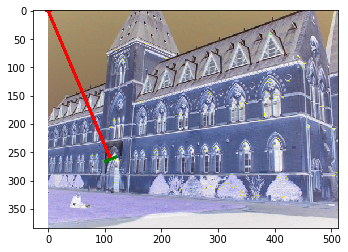

In [29]:
my_main()